In [11]:
import warnings
warnings.filterwarnings('ignore')
import time
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn import linear_model 
from sklearn.svm import SVC
from numba import jit


# Importation  et retraitement des données

In [2]:
df = pd.read_csv("Data_Satisfaction_retraitement4.csv")

df = df.dropna(axis = 0, how = "all", subset =["Commentaires_reduit"])

y = df["star"]
Meta_Matrix = df.drop(["star","Commentaires_reduit"], axis =1).to_numpy()

In [3]:
y = y.replace(to_replace = [1,2,3,4,5], value = [0,1,1,1,2])

In [4]:
vectorizer = TfidfVectorizer(min_df = 50)
#vectorizer = CountVectorizer(min_df = 150)
Com_Matrix = vectorizer.fit_transform(df["Commentaires_reduit"]).todense()
#X = Com_Matrix
X = np.concatenate([Com_Matrix,Meta_Matrix],axis=1)

In [5]:
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 100)

# Modeles de machine learning 

In [12]:
gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.3, max_depth=1, random_state=0).fit(X_train, y_train)
print("gb score :", gb.score(X_test,y_test))
rf = RandomForestClassifier(max_features = "log2", random_state= 0).fit(X_train, y_train)
print("rf score :", rf.score(X_test,y_test))
svc = SVC(C= 0.1 , kernel ="linear", random_state= 0).fit(X_train, y_train)
print("scv score :", svc.score(X_test,y_test))
rl = linear_model.LogisticRegression(C = 0.1, max_iter = 100, random_state= 0).fit(X_train, y_train)
print("rl score :", rl.score(X_test,y_test))

gb score : 0.8293269230769231
rf score : 0.8206129807692307
scv score : 0.796875
rl score : 0.8091947115384616


In [14]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('gb', gb), ('rf', rf), ('svc', svc), ('lr', rl)], voting='hard').fit(X_train,y_train) 

In [18]:
print("vclf score :", vclf.score(X_test,y_test))

vclf score : 0.8125


# Reseau de neurone Dense

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense ,  Dropout
from tensorflow.keras.models import Model

model = Sequential()
model.add(Input(shape = X_train.shape[1]))
model.add(Dense(6, activation="tanh"))
model.add(Dense(3, activation ="softmax"))

model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [49]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reducelr = ReduceLROnPlateau(monitor = 'val_accuracy',
                        min_delta = 0.01,
                        patience = 10,
                        factor = 0.5, 
                        cooldown = 5,
                        verbose = 1)


from tensorflow.keras.callbacks import EarlyStopping 
earlystop = EarlyStopping(monitor = 'val_accuracy',
                    min_delta = 0.001,
                    patience = 10,
                    verbose = 1,
                    restore_best_weights = True)

In [50]:
model_history = model.fit (X_train, y_train, epochs = 50, batch_size = 200, validation_split = 0.2, callbacks= [reducelr,earlystop])

Epoch 1/50
54/54 [==============================] - 0s 3ms/step - loss: 1.0123 - accuracy: 0.5886 - val_loss: 0.9237 - val_accuracy: 0.7682 - lr: 0.0010
Epoch 2/50
54/54 [==============================] - 0s 2ms/step - loss: 0.8410 - accuracy: 0.7940 - val_loss: 0.7778 - val_accuracy: 0.7874 - lr: 0.0010
Epoch 3/50
54/54 [==============================] - 0s 2ms/step - loss: 0.7101 - accuracy: 0.8081 - val_loss: 0.6730 - val_accuracy: 0.7926 - lr: 0.0010
Epoch 4/50
54/54 [==============================] - 0s 2ms/step - loss: 0.6199 - accuracy: 0.8130 - val_loss: 0.6040 - val_accuracy: 0.7994 - lr: 0.0010
Epoch 5/50
54/54 [==============================] - 0s 2ms/step - loss: 0.5612 - accuracy: 0.8168 - val_loss: 0.5607 - val_accuracy: 0.8032 - lr: 0.0010
Epoch 6/50
54/54 [==============================] - 0s 2ms/step - loss: 0.5224 - accuracy: 0.8191 - val_loss: 0.5313 - val_accuracy: 0.8080 - lr: 0.0010
Epoch 7/50
54/54 [==============================] - 0s 2ms/step - loss: 0.4963 - a

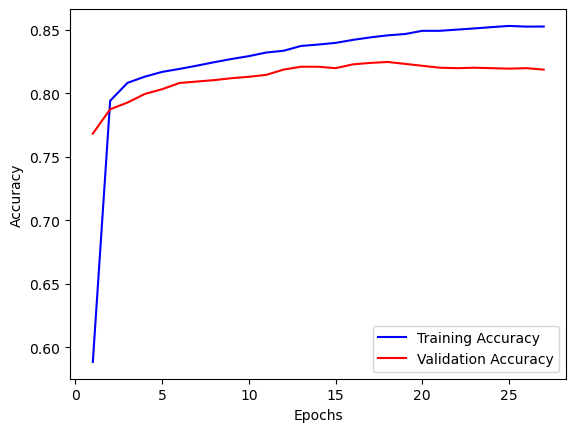

In [51]:
import matplotlib.pyplot as plt

train_acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entraînement
plt.plot(np.arange(1 , max(model_history.epoch)+2, 1),
         model_history.history['accuracy'],
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de test
plt.plot(np.arange(1 , max(model_history.epoch)+2, 1),
         model_history.history['val_accuracy'], 
         label = 'Validation Accuracy',
         color = 'red')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()

In [52]:
test_pred = model.predict(X_test)

y_test_class = y_test
y_pred_class = np.argmax(test_pred,axis=1)

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class)) 

104/104 [==============================] - 0s 600us/step
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       980
           1       0.77      0.73      0.75      1178
           2       0.83      0.84      0.83      1170

    accuracy                           0.82      3328
   macro avg       0.82      0.82      0.82      3328
weighted avg       0.82      0.82      0.82      3328

[[874 104   2]
 [108 865 205]
 [ 25 159 986]]
